In [89]:
import matplotlib.pyplot as plt
import torch
from pathlib import PurePath
import dill as pickle
from config import *
import matplotlib.pyplot as plt
import numpy as np
import scipy
import math
import pandas as pd

In [90]:
grid_N = 33
modelName = "Two_Dim_DefDifONet"

In [91]:
with open(PurePath(pathTrainedModels, modelName +".pkl"), "rb") as f:
    model = pickle.load(f).to("cuda:0")

In [92]:
def energyNNModel(xy,q11, q12 ):
    '''
    Computes the LDG energy for a torch model. This uses autograd, hence pytorch.
    '''
    eps = 0.02
    batchSize = q11.shape[0]
    q11_gradient = torch.autograd.grad(q11.view(-1,1), xy,
                                     torch.ones((batchSize, 1), requires_grad = True).to("cuda"),
                                       allow_unused=True, create_graph=True)[0]
    q12_gradient = torch.autograd.grad(q12.view(-1,1), xy,
                                     torch.ones((batchSize, 1), requires_grad = True).to("cuda"),
                                       allow_unused=True, create_graph=True)[0]
    energiesAtPoints = q11_gradient[:,0] **2 + q11_gradient[:,1] **2 +q12_gradient[:,0] **2 +q12_gradient[:,1] **2 + (1/eps) **2 * (q11 **2 + q12 **2 -1)**2

    return torch.nanmean(energiesAtPoints)


In [93]:
def l2Difference(x1, y1,Q11_1, Q12_1, x2, y2,Q11_2, Q12_2 ):
    '''
    Computes the L2 Difference of the respective funcitons under the assumption, that the x and y coordinates contain the same values, but in different orderings, i.e. same grid but different ordering of the points in the grid.
    '''

    df1_by_x = pd.DataFrame({"x":x1, "y":y1, "q11":Q11_1.reshape(-1), "q12":Q12_1.reshape(-1)})
    df1_by_x = df1_by_x.sort_values(by=["x", "y"])

    df2_by_x = pd.DataFrame({"x":x2, "y":y2, "q11":Q11_2.reshape(-1), "q12":Q12_2.reshape(-1)})
    df2_by_x = df2_by_x.sort_values(by=["x", "y"])

    q11_1 = df1_by_x["q11"].to_numpy()
    q12_1 = df1_by_x["q12"].to_numpy()

    q11_2 = df2_by_x["q11"].to_numpy()
    q12_2 = df2_by_x["q12"].to_numpy()

    return np.sqrt(np.nanmean( (q11_1 - q11_2)**2 + (q12_1 - q12_2)**2) )




In [94]:
xs = torch.linspace(0.0, 1.0, grid_N, device="cpu")
ys = torch.linspace(0.0, 1.0, grid_N, device="cpu")

X, Y = torch.meshgrid(xs, ys, indexing='xy')
jointInputVec = torch.cat((X.reshape(-1,1),Y.reshape(-1,1)) , dim = 1 ).to("cuda")
jointInputVec.requires_grad = True

modelOut = model( jointInputVec)

Q11_torch = modelOut['out1']
Q12_torch = modelOut['out2']

Q11_NN = []
Q12_NN = []

for i in range(6):
    Q11_NN.append(Q11_torch[i].detach().cpu().numpy())
    Q12_NN.append(Q12_torch[i].detach().cpu().numpy())
    

In [95]:
energyNNModel(jointInputVec,Q11_torch[5], Q12_torch[5] )

tensor(582.9578, device='cuda:0', grad_fn=<DivBackward0>)

In [96]:
x = X.detach().cpu().numpy()
y = Y.detach().cpu().numpy()

In [97]:
res1 = scipy.io.loadmat("data/Reduced2DimLDG/trueSolution/data_R1.mat")
res2 = scipy.io.loadmat("data/Reduced2DimLDG/trueSolution/data_R2.mat")
res3 = scipy.io.loadmat("data/Reduced2DimLDG/trueSolution/data_R3.mat")
res4 = scipy.io.loadmat("data/Reduced2DimLDG/trueSolution/data_R4.mat")
res5 = scipy.io.loadmat("data/Reduced2DimLDG/trueSolution/data_15112024.mat")
res6 = scipy.io.loadmat("data/Reduced2DimLDG/trueSolution/data_D2.mat")
coordinates = scipy.io.loadmat("data/Reduced2DimLDG/trueSolution/data_test.mat")

In [98]:
coordinates["c4n"]

array([[0.     , 0.     ],
       [1.     , 0.     ],
       [0.     , 1.     ],
       ...,
       [0.90625, 1.     ],
       [0.96875, 0.9375 ],
       [0.96875, 1.     ]], shape=(1089, 2))

In [99]:
xy = coordinates["c4n"]
Q11_1 = res1["p1"].toarray()
Q12_1 = res1["q1"].toarray()

Q11_2 = res2["p1"].toarray()
Q12_2 = res2["q1"].toarray()

Q11_3 = res3["p1"].toarray()
Q12_3 = res3["q1"].toarray()

Q11_4 = res4["p1"].toarray()
Q12_4 = res4["q1"].toarray()

Q11_5 = res5["p1"].toarray()
Q12_5 = res5["q1"].toarray()

Q11_6 = res6["p1"].toarray()
Q12_6 = res6["q1"].toarray()

In [100]:
Q11_fem = []
Q12_fem = []

Q11_fem.append(res1["p1"].toarray())
Q12_fem.append(res1["q1"].toarray())

Q11_fem.append(res2["p1"].toarray())
Q12_fem.append(res2["q1"].toarray())

Q11_fem.append(res3["p1"].toarray())
Q12_fem.append(res3["q1"].toarray())

Q11_fem.append(res4["p1"].toarray())
Q12_fem.append(res4["q1"].toarray())

Q11_fem.append(res5["p1"].toarray())
Q12_fem.append(res5["q1"].toarray())

Q11_fem.append(res6["p1"].toarray())
Q12_fem.append(res6["q1"].toarray())


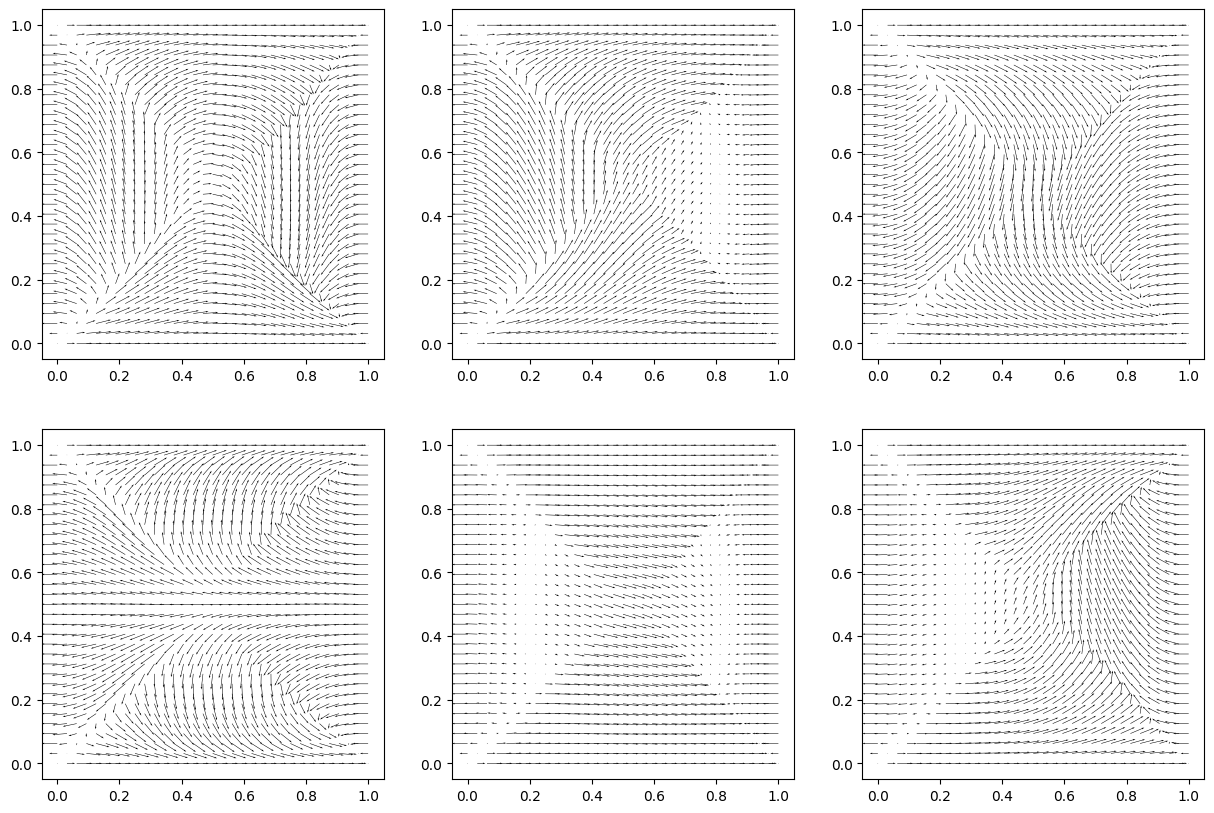

In [101]:
fig, ax = plt.subplots(2, 3)
fig.set_figheight(10)
fig.set_figwidth(15)
ax[0,0].quiver(
                x, y,                             
                Q11_NN[0],
                Q12_NN[0],      
                angles='xy', scale_units='xy', scale=20, width=0.0015
                )
ax[1,0].quiver(
                x, y,                             
                Q11_NN[1],
                Q12_NN[1],      
                angles='xy', scale_units='xy', scale=20, width=0.0015
                )
ax[0,1].quiver(
                x, y,                             
                Q11_NN[2],
                Q12_NN[2],      
                angles='xy', scale_units='xy', scale=20, width=0.0015
                )
ax[1,1].quiver(
                x, y,                             
                Q11_NN[3],
                Q12_NN[3],      
                angles='xy', scale_units='xy', scale=20, width=0.0015
                )
ax[0,2].quiver(
                x, y,                             
                Q11_NN[4],
                Q12_NN[4],      
                angles='xy', scale_units='xy', scale=20, width=0.0015
                )
ax[1,2].quiver(
                x, y,                             
                Q11_NN[5],
                Q12_NN[5],      
                angles='xy', scale_units='xy', scale=20, width=0.0015
                )

In [102]:
computeEnergy(xy[:,0], xy[:,1], Q11_fem[3], Q12_fem[4])

NameError: name 'computeEnergy' is not defined

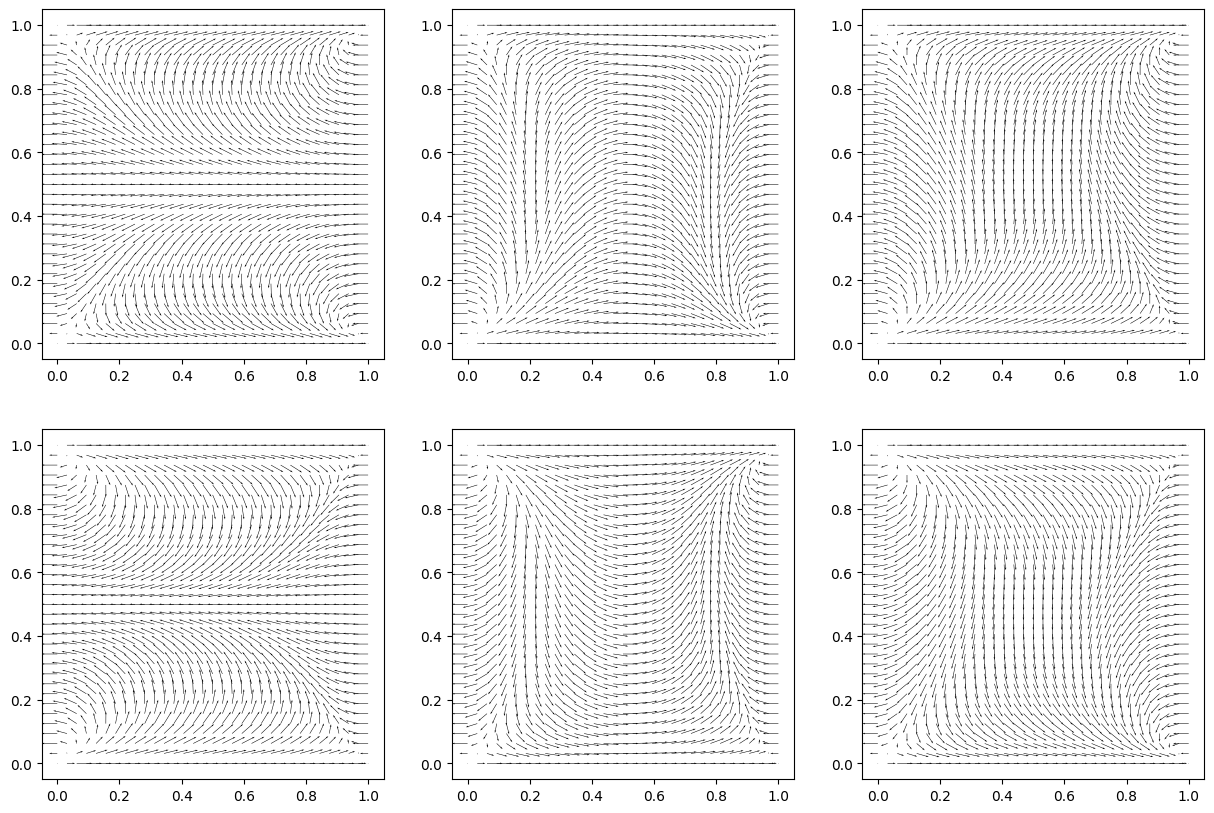

In [47]:
fig, ax = plt.subplots(2, 3)
fig.set_figheight(10)
fig.set_figwidth(15)
ax[0,0].quiver(
                xy[:,0], xy[:,1],                             
                Q11_fem[0],
                Q12_fem[0],      
                angles='xy', scale_units='xy', scale=20, width=0.0015
                )
ax[1,0].quiver(
                xy[:,0], xy[:,1],                             
                Q11_fem[1],
                Q12_fem[1],      
                angles='xy', scale_units='xy', scale=20, width=0.0015
                )
ax[0,1].quiver(
                xy[:,0], xy[:,1],                             
                Q11_fem[2],
                Q12_fem[2],      
                angles='xy', scale_units='xy', scale=20, width=0.0015
                )
ax[1,1].quiver(
                xy[:,0], xy[:,1],                             
                Q11_fem[3],
                Q12_fem[3],      
                angles='xy', scale_units='xy', scale=20, width=0.0015
                )
ax[0,2].quiver(
                xy[:,0], xy[:,1],                             
                Q11_fem[4],
                Q12_fem[4],      
                angles='xy', scale_units='xy', scale=20, width=0.0015
                )
ax[1,2].quiver(
                xy[:,0], xy[:,1],                             
                Q11_fem[5],
                Q12_fem[5],      
                angles='xy', scale_units='xy', scale=20, width=0.0015
                )

In [74]:
def computeEnergy(x, y, Q11, Q12):
    """We use central finite differences to compute the gradient in the formula for the energy functional.

    Args:
        x (numpy.array): x
        y (numpy.array): y
        Q11 (numpy.array): Q11
        Q12 (numpy.array): Q12
    """
    # grid size
    n = 33
    # step size grid
    h = 1/(n-1)

    hx2 =2 *h

    eps = 0.02
    

    df_by_x = pd.DataFrame({"x":xy[:,0], "y":xy[:,1], "q11":Q11_1.reshape(-1), "q12":Q12_1.reshape(-1)})
    df_by_x = df_by_x.sort_values(by=["x", "y"])

    df_by_y = pd.DataFrame({"x":xy[:,0], "y":xy[:,1], "q11":Q11_1.reshape(-1), "q12":Q12_1.reshape(-1)})
    df_by_y = df_by_y.sort_values(by=["y", "x"])

    dq11_dx_AtPoints    = np.zeros((n-2, n-2))
    dq11_dy_AtPoints    = np.zeros((n-2, n-2))
    dq12_dx_AtPoints    = np.zeros((n-2, n-2))
    dq12_dy_AtPoints    = np.zeros((n-2, n-2))
    q11_AtPoints        = np.zeros((n-2, n-2))
    q12_AtPoints        = np.zeros((n-2, n-2))

    for i in range(n-2):
        # for partial derivatives in y direction
        col_Q11 = df_by_x[i*33:(i+1)*33]["q11"].to_numpy()
        col_Q12 = df_by_x[i*33:(i+1)*33]["q12"].to_numpy()

        # for partial derivatives in x direction
        row_Q11 = df_by_y[i*33:(i+1)*33]["q11"].to_numpy()
        row_Q12 = df_by_y[i*33:(i+1)*33]["q12"].to_numpy()

        dq11_dx = (row_Q11[2:] - row_Q11[:31])/hx2
        dq11_dy = (col_Q11[2:] - col_Q11[:31])/hx2

        dq12_dx = (row_Q12[2:] - row_Q12[:31])/hx2
        dq12_dy = (col_Q12[2:] - col_Q12[:31])/hx2

        dq11_dx_AtPoints[i,:]    = (row_Q11[2:] - row_Q11[:31])/hx2
        dq11_dy_AtPoints[:,i]    = (col_Q11[2:] - col_Q11[:31])/hx2
        dq12_dx_AtPoints[i,:]    = (row_Q12[2:] - row_Q12[:31])/hx2
        dq12_dy_AtPoints[:,i]    = (col_Q12[2:] - col_Q12[:31])/hx2

        q11_AtPoints[i,:] = col_Q11[1:32]
        q12_AtPoints[i,:] = col_Q12[1:32]
        

    enegriesAtPoints = dq11_dx_AtPoints**2 + dq11_dy_AtPoints**2 + dq12_dx_AtPoints**2 + dq12_dy_AtPoints**2 + (1/eps)**2 * (q11_AtPoints**2 +q12_AtPoints**2 - 1)**2

    return np.mean(enegriesAtPoints)

